In [1]:
import os
print(os.getcwd())

/Users/taziy/DeepCNN-as-a-Service


Import needed libraries and classes

In [2]:
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from contextlib import redirect_stdout
from zipfile import ZipFile
import glob
import re
from tensorflow.keras.callbacks import ModelCheckpoint

Unzip uploaded user input to 'data_template' directory

In [3]:
data_fname = 'cars.zip'
with ZipFile(data_fname,'r') as zip_file:
            zip_file.extractall('data_template')

Create a list of labels. 

In [4]:
# First, let's store the number of classes of this particular dataset
list_labels = [re.sub("data_template/*",'',l) for l in glob.glob("data_template/*")]

for i in range(len(list_labels)):
    list_labels[i] = re.sub("[^a-z_A-Z]","",list_labels[i])

print ("The labels are : " + str(list_labels))

# Check how many images per label (it will be useful later for class imbalance handling) and store that in a dictionary (also helpful for prepare train/valid/test)

labels_summary = {}
for lab in list_labels :
    to_add = {lab: len(os.listdir("data_template/"+lab+"/"))}
    labels_summary.update(to_add)
print(labels_summary)    

# Create directories for training/validation/testing

# We will have 3 new folders (training,validation,test) and each will contain subfolders one per label class

The labels are : ['acura', 'alfa_romeo', 'aston_martin']
{'acura': 1174, 'alfa_romeo': 290, 'aston_martin': 574}


Create directories for training, validation, and testing populations

In [5]:
for fold in ["training","validation","testing"]:
    for lab in list_labels :
        os.makedirs(fold+'/'+lab)

# # We will use shutils.move to move the data selected randomly to the corresponding folder
        
# # Take 70 % of the data for training from each class        
for lab in list_labels:
    for i in random.sample(glob.glob('data_template/'+lab+'/*'), int(labels_summary[lab]*0.7)):
        shutil.move(i, 'training/'+lab)  
        
# # Take 10 % of the data for validation from each class 
for lab in list_labels:
    for i in random.sample(glob.glob('data_template/'+lab+'/*'), int(labels_summary[lab]*0.1)):
        shutil.move(i, 'validation/'+lab)

# # Take the remaining 20% for testing
for lab in list_labels:
    for i in glob.glob('data_template/'+lab+'/*'):
        shutil.move(i, 'testing/'+lab)

Set initial values for max val_accuracy, epoch of max val_acc, and model type of max val_acc

In [6]:
#max val acccuracy, epoch at max val_acc, model type of max val_acc
mx = 0
epochAtMx = 0
modelType = ""

Set initial hyperparameters for training runs

In [7]:
batch_size=16
n_epochs=5
lr = 0.001
models = ['vgg16','mobilenet','inception','inception_resnet','xception']


create directory for saved model files with highest val_accuracy

In [8]:
#create directory for saved model files with highest val_accuracy
save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)

Variables to be set for each model type and training run

In [9]:
#model params to set for each iteration
preprocessingFunc = None
model = None
removeLayer = 0
freezeLayers = 0
#batches to set for each iteration
train_batches = None
valid_batches = None
test_batches = None

Perform training for each model type, saving the best models and validation accuracies. <br>Record best overall val_accuracy,epoch,model

In [10]:
for i in range(len(models)):
  model_name = models[i]
  #callback for saving checkpoint at best validation accuracy
  model_filename = '%s_model.{epoch:03d}.h5' % model_name
  filepath = os.path.join(save_dir, model_filename)
  # prepare callback for model saving
  checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

  if model_name == 'vgg16':
    preprocessingFunc = tf.keras.applications.vgg16.preprocess_input
    model = tf.keras.applications.vgg16.VGG16()
    removeLay = -2
    freezeLay = -3
  elif model_name == 'mobilenet':
    preprocessingFunc = tf.keras.applications.mobilenet.preprocess_input
    model = tf.keras.applications.mobilenet.MobileNet()
    removeLay = -6
    freezeLay = -5
  elif model_name == 'inception':
    preprocessingFunc = tf.keras.applications.inception_v3.preprocess_input
    model = tf.keras.applications.inception_v3.InceptionV3()
    removeLay = -1
    freezeLay = -5
  elif model_name == 'inception_resnet':
    preprocessingFunc = tf.keras.applications.inception_resnet_v2.preprocess_input
    model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2()
    removeLay = -1
    freezeLay = -5
  elif model_name == 'xception':
    preprocessingFunc = tf.keras.applications.xception.preprocess_input
    model = tf.keras.applications.xception.Xception()
    removeLay = -1
    freezeLay = -5
  
  train_batches = ImageDataGenerator(preprocessing_function=preprocessingFunc) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
  valid_batches = ImageDataGenerator(preprocessing_function=preprocessingFunc) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
  test_batches = ImageDataGenerator(preprocessing_function=preprocessingFunc) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)
  
  x = model.layers[removeLay].output  # we remove the output. layer that we  replace with the following line
  output = Dense(units=len(list_labels), activation='softmax')(x)
  model_new = Model(inputs=model.input, outputs=output)
  for layer in model_new.layers[:freezeLay]:  # retrain fc1 , fc2 and prediction layer
    layer.trainable = False
  model_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  #model_new.summary()
  history_model = model_new.fit(x=train_batches,
              validation_data=valid_batches,
              validation_steps=len(valid_batches),
              epochs=n_epochs,
              verbose=1,callbacks=[checkpoint]
  )
  #print the max validation accuracy and the epoch at which it occured
  for k in range(len(history_model.history['val_accuracy'])):
    if history_model.history['val_accuracy'][k] > mx:
      mx = history_model.history['val_accuracy'][k]
      epochAtMx = k + 1
      modelType = model_name
  print('max val acc: {}'.format(mx))
  print('at epoch: {}'.format(epochAtMx))
  print('best model: {}'.format(modelType))


553467904/553467096 [==============================] - 4s 0us/step
Found 1425 images belonging to 3 classes.
Found 203 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/5
90/90 [==============================] - ETA: 0s - loss: 4.5917 - accuracy: 0.6421
Epoch 00001: val_accuracy improved from -inf to 0.78818, saving model to /content/saved_models/vgg16_model.001.h5
90/90 [==============================] - 16s 172ms/step - loss: 4.5917 - accuracy: 0.6421 - val_loss: 0.5871 - val_accuracy: 0.7882
Epoch 2/5
90/90 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8926
Epoch 00002: val_accuracy improved from 0.78818 to 0.85714, saving model to /content/saved_models/vgg16_model.002.h5
90/90 [==============================] - 37s 414ms/step - loss: 0.4471 - accuracy: 0.8926 - val_loss: 0.9724 - val_accuracy: 0.8571
Epoch 3/5
90/90 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9558
Epoch 00003: val_accuracy did not i

Select and load the model with highest recorded val_accuracy

In [11]:
bestModelFile = modelType + ('_model.%03d.h5' % epochAtMx)
bestModel = keras.models.load_model('saved_models/'+bestModelFile)
print('best model file: {}'.format(bestModelFile))

best model file: mobilenet_model.004.h5


Set model attributes according to best model type

In [12]:

if modelType == 'vgg16':
  preprocessingFunc = tf.keras.applications.vgg16.preprocess_input
  removeLay = -2
  freezeLay = -3
elif modelType == 'mobilenet':
  preprocessingFunc = tf.keras.applications.mobilenet.preprocess_input
  removeLay = -6
  freezeLay = -5
elif modelType == 'inception':
  preprocessingFunc = tf.keras.applications.inception_v3.preprocess_input
  removeLay = -1
  freezeLay = -5
elif modelType == 'inception_resnet':
  preprocessingFunc = tf.keras.applications.inception_resnet_v2.preprocess_input
  removeLay = -1
  freezeLay = -5
elif modelType == 'xception':
  preprocessingFunc = tf.keras.applications.xception.preprocess_input
  removeLay = -1
  freezeLay = -5


Initialize new callback for best model

In [14]:
#callback for saving checkpoint at best validation accuracy
model_name = 'bestModel'
model_filename = '%s_model.{epoch:03d}.h5' % model_name
filepath = os.path.join(save_dir, model_filename)
# prepare callback for model saving
checkpoint = ModelCheckpoint(filepath=filepath,
                          monitor='val_accuracy',
                          verbose=1,
                          save_best_only=True)

Update hyperparameters for tuning the best model. <br>
Create new batches for best model.<br>
Then start training.

In [15]:
#set new number of epochs , batch size, lern rate for best model tuning
n_epochs=15
batch_size = 32
lr = 0.00001
#create batches for new training round with updated batch size
train_batches = ImageDataGenerator(rotation_range=5,horizontal_flip=True,preprocessing_function=preprocessingFunc) .flow_from_directory(directory="training/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
valid_batches = ImageDataGenerator(rotation_range=5,horizontal_flip=True,preprocessing_function=preprocessingFunc) .flow_from_directory(directory="validation/", target_size=(224,224), classes=list_labels, batch_size=batch_size)
test_batches = ImageDataGenerator(preprocessing_function=preprocessingFunc) .flow_from_directory(directory="testing", target_size=(224,224), classes=list_labels, batch_size=batch_size, shuffle=False)

opt = keras.optimizers.Adam(learning_rate=lr)
bestModel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history_bestModel = bestModel.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=n_epochs,
            verbose=1,callbacks=[checkpoint]
)

Found 1425 images belonging to 3 classes.
Found 203 images belonging to 3 classes.
Found 410 images belonging to 3 classes.
Epoch 1/15
45/45 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9930
Epoch 00001: val_accuracy improved from -inf to 0.89163, saving model to /content/saved_models/bestModel_model.001.h5
45/45 [==============================] - 19s 428ms/step - loss: 0.0286 - accuracy: 0.9930 - val_loss: 0.3921 - val_accuracy: 0.8916
Epoch 2/15
45/45 [==============================] - ETA: 0s - loss: 0.0317 - accuracy: 0.9923
Epoch 00002: val_accuracy improved from 0.89163 to 0.90640, saving model to /content/saved_models/bestModel_model.002.h5
45/45 [==============================] - 19s 413ms/step - loss: 0.0317 - accuracy: 0.9923 - val_loss: 0.2986 - val_accuracy: 0.9064
Epoch 3/15
45/45 [==============================] - ETA: 0s - loss: 0.0205 - accuracy: 0.9972
Epoch 00003: val_accuracy improved from 0.90640 to 0.92611, saving model to /content/saved_

Record best model's top validation accuracy and epoch.<br>
Model h5 file saved by checkpoint callback.

In [19]:
#print the max validation accuracy and the epoch at which it occured
for k in range(len(history_bestModel.history['val_accuracy'])):
  if history_bestModel.history['val_accuracy'][k] > mx:
    mx = history_bestModel.history['val_accuracy'][k]
    epochAtMx = k + 1
    modelType = model_name
print('max val acc: {}'.format(mx))
print('at epoch: {}'.format(epochAtMx))
print('best model: {}'.format(modelType))

max val acc: 0.9261083602905273
at epoch: 3
best model: bestModel


Functions for displaying confusion matrix and training history.

In [16]:
def plot_confusion_matrix(cm, classes,name,
                          cmap=plt.cm.Blues,save=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if save :
        plt.savefig("./"+name)

In [17]:
def plot_history(history,name="",save=True):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if save:
        plt.savefig("./"+name+"_loss.png")
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if save :
        plt.savefig("./"+name+"_accuracy.png")

Show confusion matrix and training history of best model training run with tuned hyperparameters.

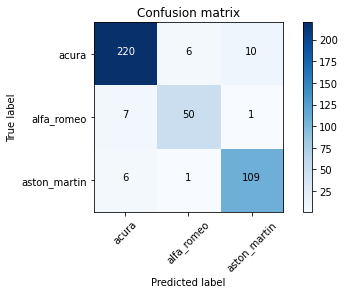

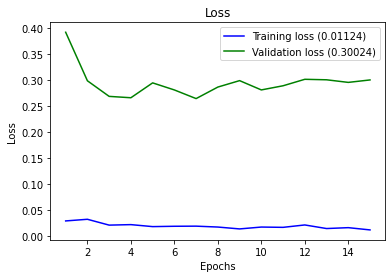

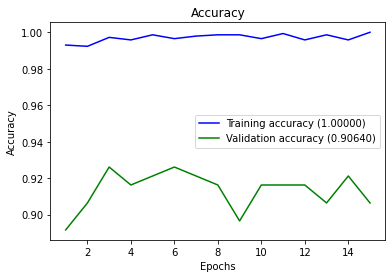

In [18]:
predictions_bestModel = bestModel.predict(x=test_batches, steps=len(test_batches), verbose=0) 
cm = confusion_matrix(y_true=test_batches.classes, y_pred=predictions_bestModel.argmax(axis=1))


plot_confusion_matrix(cm=cm, classes=list(test_batches.class_indices.keys()),name="confusion_matrix_bestModel.png")
plt.show()

plot_history(history_bestModel,name="history_bestModel")

plt.show()